In [37]:
%reset
%env HSA_OVERRIDE_GFX_VERSION=10.3.0

env: HSA_OVERRIDE_GFX_VERSION=10.3.0


In [38]:
import os
import time
import warnings

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchinfo import summary
from Classes import StockData, LSTM

import matplotlib.pyplot as plt

# Parameters
TRAIN_DATASET_DIRECTORY = 'StockData/Datasets/DS5.4_FOREX.pt'
TEST_DATASET_DIRECTORY = 'StockData/Datasets/DS5.5_FOREX_TEST.pt'
DATASET_SPLIT = [0.7,0.3]
NUM_EPOCHS = 50

MODEL_DIRECTORY = 'Models/I(90,22)_O(14,1)_128HS_5L_64B'
MODEL_VERSION = 'BASE.pt'
MODEL_SAVE_NAME = '[DS5.1_FOREX-DS5.5].pt'

In [39]:
model_parameters = MODEL_DIRECTORY[7:].split('_')

INPUT_LENGTH = int(model_parameters[0][2:-1].split(',')[0])
INPUT_FEATURES = int(model_parameters[0][2:-1].split(',')[1])
OUTPUT_LENGTH = int(model_parameters[1][2:-1].split(',')[0])
OUTPUT_FEATURES = int(model_parameters[1][2:-1].split(',')[1])

MODEL_HIDDEN_SIZE = int(model_parameters[2][:-2])
MODEL_NUM_LAYERS = int(model_parameters[3][:-1])
BATCH_SIZE = int(model_parameters[4][:-1])

In [40]:
print('Model parameters as follows:')
print(f'Input shape - ({INPUT_LENGTH},{INPUT_FEATURES})')
print(f'Output shape - ({OUTPUT_LENGTH},{OUTPUT_FEATURES})')
print('----------------------------------')
print(f'Hidden size - {MODEL_HIDDEN_SIZE}')
print(f'Number of layers - {MODEL_NUM_LAYERS}')
print(f'Batch size - {BATCH_SIZE}')

Model parameters as follows:
Input shape - (90,22)
Output shape - (14,1)
----------------------------------
Hidden size - 128
Number of layers - 5
Batch size - 64


In [41]:
torch.cuda.is_available()
device = torch.device('cuda')

In [42]:
model = LSTM(INPUT_FEATURES,MODEL_HIDDEN_SIZE,MODEL_NUM_LAYERS,OUTPUT_LENGTH)
model.load_state_dict(torch.load(f'{MODEL_DIRECTORY}/{MODEL_VERSION}'))
model.to(device)

LSTM(
  (lstm): LSTM(22, 128, num_layers=5, dropout=0.2)
  (fc): Linear(in_features=128, out_features=14, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [43]:
main_dataset = torch.load(TRAIN_DATASET_DIRECTORY)
train_dataset = torch.load(TEST_DATASET_DIRECTORY)

train_dataset, validation_dataset = torch.utils.data.random_split(main_dataset, DATASET_SPLIT)

In [44]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE,shuffle=False, drop_last=True)

In [45]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses = []
test_losses = []
epoch_times = []

In [46]:
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss = 0

    # Train for epoch
    model.train()
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.float().to(device), targets.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).float()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    # Evaluate for epoch
    with torch.no_grad():
        test_loss = 0
        model.eval()

        for inputs, targets in validation_dataloader:
            inputs, targets = inputs.float().to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

        test_loss /= len(validation_dataloader)
        test_losses.append(test_loss)

    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f} | Time taken: {epoch_time:.1f} seconds")

Epoch 1/50, Train Loss: 0.00263439, Test Loss: 0.00222793 | Time taken: 3.1 seconds
Epoch 2/50, Train Loss: 0.00218795, Test Loss: 0.00193432 | Time taken: 3.3 seconds
Epoch 3/50, Train Loss: 0.00180918, Test Loss: 0.00168992 | Time taken: 3.2 seconds
Epoch 4/50, Train Loss: 0.00158837, Test Loss: 0.00148541 | Time taken: 3.2 seconds
Epoch 5/50, Train Loss: 0.00132844, Test Loss: 0.00129404 | Time taken: 3.2 seconds
Epoch 6/50, Train Loss: 0.00117690, Test Loss: 0.00093077 | Time taken: 3.2 seconds
Epoch 7/50, Train Loss: 0.00093990, Test Loss: 0.00079710 | Time taken: 3.2 seconds
Epoch 8/50, Train Loss: 0.00084999, Test Loss: 0.00085998 | Time taken: 3.2 seconds
Epoch 9/50, Train Loss: 0.00079910, Test Loss: 0.00079676 | Time taken: 3.2 seconds
Epoch 10/50, Train Loss: 0.00067446, Test Loss: 0.00055091 | Time taken: 3.2 seconds
Epoch 11/50, Train Loss: 0.00060127, Test Loss: 0.00047539 | Time taken: 3.2 seconds
Epoch 12/50, Train Loss: 0.00055864, Test Loss: 0.00046240 | Time taken: 3

In [47]:
torch.save(model.state_dict(), f'{MODEL_DIRECTORY}/{MODEL_SAVE_NAME}')

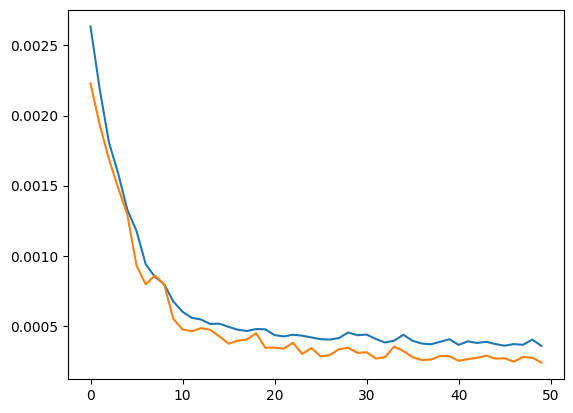

In [48]:
plt.plot(train_losses)
plt.plot(test_losses)